## 1. Ablation Study 실습 : CIFAR-10 데이터셋 준비하기

 - ResNet의 논문을 본 후 직접 실험을 통해 성능을 평가하고 다른 실험에 적용해본다.

### 1) CIFAR-10 

패키지 설치

- `$` pip install tensorflow-datasets

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

데이터셋이 준비되면 클래스의 수와 클래스에 따른 이름을 볼 수 있다. DatasetBuilder의 info를 통해 정보를 확인한다.

```
❗️ tfds.load()는 기본적으로 ~/tensorflow_datasets 경로에 데이터셋을 다운로드합니다. 데이터셋 크기가 커서 하나의 폴더에 모아놓고 사용하는 것도 좋은 방법이므로, ~/aiffel 프로젝트 폴더가 아닌 기본 경로에 다운 받아 사용하시면 됩니다. 혹시 데이터셋 경로를 바꾸고 싶으시다면, data_dir 인자를 사용하세요.

```

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


Tensorflow의 데이터셋은 Numpy가 아니기 때문에 `ds_train.shape` 같은게 존재하지 않는다.

### Input Normalization
1. `Data Normalization`은 데이터의 범위를 사용자가 원하는 범위로 제한하는 것이다.
2. 이미지 데이터의 경우 픽셀 정보를 0 ~ 255 사이로 가지는데 이를 255로 나눠주면 0 ~ 1 사이의 값으로 바뀌게된다.
3. 수식으로 간단하게 쓴다면 (정규화하고자 하는 값 - 데이터 값들 중 최소값) / (데이터 값들 중 최대값 - 데이터 값들 중 최소값)이다.

`Data Normalization을 하는 이유`는 머신러닝에서 scale이 큰 `feature의 영향이 비대해지는 것을 방지`하고, 딥러닝에서 `Local optimum에 빠질 위험을 줄이는`(학습속도 향상) 것이다.

In [6]:
# 모델에 넣어주기 전에 각 채널별 최대값인 255로 정규화해준다.
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

MNIST 데이터셋 클래스는 0부터 9까지 숫자, 총 10가지가 있다. 10개 클래스를 가진다는 말인데 아래 코드를 통해 각 클래스가 어떻게 구성되는지, 어떤 이미지가 있는지 확인해보자.

In [8]:
ds_info.features["label"].num_classes

10

In [9]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

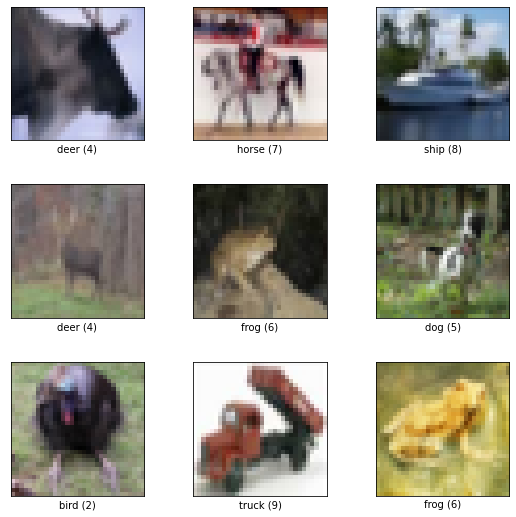

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

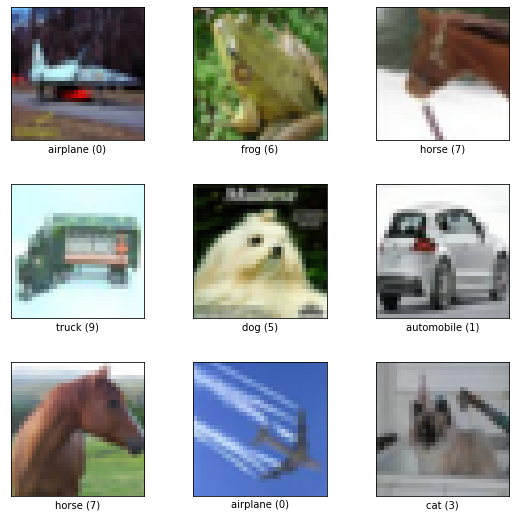

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

## 2. Ablation Study 실습 : 블록 구성하기

1. 구현 시에 반복되는 부분을 줄여서 하이퍼파라미터 또는 변수를 변경할때 손쉽게 바꿀 수 있게 만드는 것이 중요하다.

2. 이렇게 딥러닝 모델에서 주요 구조를 모듈화해 조금씩 바꾸어 쓸 수 있는 단위를 `블록(block)`이라고 한다. `레이어(layer)`는 기본적으로 텐서플로우, 케라스, 파이토치 등에서 제공하는 단위이다.

#### ResNet을 바로 구현하는 것은 어려울 수 있기 때문에 조금 더 간단한 블록이 반복되는 VGG를 예시로 구현한다.

VGG의 모델 구조의 특징을 알아본다.
1. 블록은 CNN 레이어 여러개와 Max Pooling 레이어 한개로 이루어진다.
2. CNN은 커널 크기가 모두 3X3이다.
3. 블록 내 CNN 레이어의 채널은 하나로 유지되지만 서로 다른 블록 간 CNN 레이어의 채널 수는 다를 수 있다. 또, 블록에 따라 CNN 레이어의 개수도 달라진다.

##### 우리는 CNN 레이어 여러개, Max Pooling 레이어 한개로 이루어져있고, CNN의 레이어 수와 채널을 조절할 수 있어야한다.

`block_num`은 레이어의 이름을 붙히기 위함이다. <br/>
`input_shape`는 summary를 출력하기 위함이다.

In [12]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

1. 위에서 만든 VGG 블록을 추가하는 함수를 이용해 `input_layer`에 추가를 해본다.
2. 데이터셋에서 확인한 32,32의 가로,세로 크기를 가지고 채널로 3을 가지므로 (32,32,3)이 된다.
3. 이 입력 레이어를 인자로 받아서 `build_vgg_block()`은 블록의 레이어를 build하고 출력값을 얻을 수 있다.
4. 케라스의 Model 클래스에서 input과 output을 정의해주면 블록의 모델을 확인해볼 수 있다.

In [13]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [14]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


## 3. Ablation Study 실습 : VGG Complete Model

기본적인 블록을 만들 수 있는 함수를 만들었으니 이를 합쳐 전체 모델을 만들 수 있는 함수를 만들어본다.

### 1) VGG-16
VGG-16, VGG-19에 따라서 같이 변화되므로 함수에 전달되어야 한다.

각 블록 별 CNN의 수와 채널을 리스트로 전달했다.

In [15]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [16]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

### 2) VGG-19
쉽게 구성(configuration)을 바꿔서 VGG-19를 만들 수 있다.

In [17]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

## 4. Ablation Study 실습 : VGG-16 vs VGG-19

VGG의 레이어의 차이를 위해 VGG-16과 VGG-19를 비교해보도록 하겠다.

In [18]:
# CIFAR-10 데이터셋 불러오기
BATCH_SIZE = 256
EPOCH = 15

In [19]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [20]:
# VGG-16 모델 만들고 훈련시키기
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/15
195/195 [==============================] - 37s 127ms/step - loss: 2.1731 - accuracy: 0.1972 - val_loss: 2.0752 - val_accuracy: 0.2810
Epoch 2/15
195/195 [==============================] - 22s 115ms/step - loss: 1.9833 - accuracy: 0.2865 - val_loss: 1.9117 - val_accuracy: 0.3355
Epoch 3/15
195/195 [==============================] - 23s 116ms/step - loss: 1.8439 - accuracy: 0.3395 - val_loss: 1.7479 - val_accuracy: 0.3952
Epoch 4/15
195/195 [==============================] - 22s 115ms/step - loss: 1.7336 - accuracy: 0.3820 - val_loss: 1.6676 - val_accuracy: 0.4002
Epoch 5/15
195/195 [==============================] - 23s 116ms/step - loss: 1.6455 - accuracy: 0.4094 - val_loss: 1.6218 - val_accuracy: 0.4262
Epoch 6/15
195/195 [==============================] - 23s 116ms/step - loss: 1.5831 - accuracy: 0.4292 - val_loss: 1.5323 - val_accuracy: 0.4354
Epoch 7/15
195/195 [==============================] - 23s 117ms/step - loss: 1.5329 - accuracy: 0.4536 - val_loss: 1.5052 - val_ac

In [21]:
# VGG-19 모델 만들고 훈련시키기
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 31s 136ms/step - loss: 2.1895 - accuracy: 0.1863 - val_loss: 2.0708 - val_accuracy: 0.2642
Epoch 2/15
195/195 [==============================] - 27s 136ms/step - loss: 2.0084 - accuracy: 0.2657 - val_loss: 1.9170 - val_accuracy: 0.3169
Epoch 3/15
195/195 [==============================] - 27s 136ms/step - loss: 1.8759 - accuracy: 0.3244 - val_loss: 1.7880 - val_accuracy: 0.3431
Epoch 4/15
195/195 [==============================] - 27s 137ms/step - loss: 1.7607 - accuracy: 0.3654 - val_loss: 1.7795 - val_accuracy: 0.3368
Epoch 5/15
195/195 [==============================] - 27s 137ms/step - loss: 1.6730 - accuracy: 0.3958 - val_loss: 1.6408 - val_accuracy: 0.4030
Epoch 6/15
195/195 [==============================] - 27s 137ms/step - loss: 1.6150 - accuracy: 0.4189 - val_loss: 1.5902 - val_accuracy: 0.4271
Epoch 7/15
195/195 [==============================] - 27s 137ms/step - loss: 1.5610 - accuracy: 0.4397 - val_loss: 1.5434 - val_ac

위의 VGG-16과 VGG-19 결과를 그래프로 그리고 비교해보도록 한다.

먼저 훈련 손실(training loss)가 어떻게 다르게 진행되는지 비교해본다

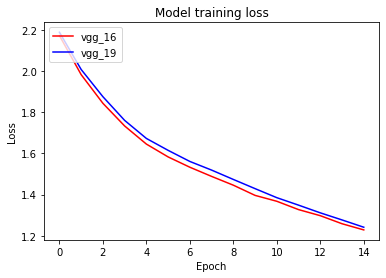

In [22]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

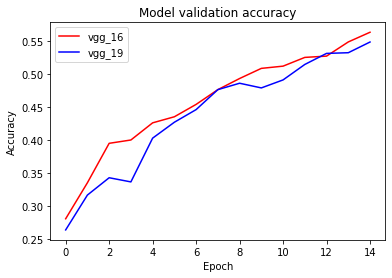

In [23]:
# 검증 정확도(validation accuracy)를 비교해본다.
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()